In [2]:
import numpy as np
import pandas as pd
from pandas import datetime
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split as tts
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
#import matplotlib.pylab as plt #for visualization
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest
import os
from matplotlib import dates as mpl_dates

In [3]:
def parser(x):
    return datetime.strptime(x,'%Y-%m-%d %H:%M')
dataset = pd.read_csv('C:/users/admin/swq/Dataset/Data7.csv',header=0, delimiter=',',index_col=0, parse_dates=[0], date_parser=parser)


 ## Dataset NaN values are filled with previous cell values

In [5]:
dataset = dataset.fillna(method ='pad') 
turb = dataset.filter(['Turb(FNU)'], axis=1)
#train_size,test_size = 1920, 3251#in paper given as 3169
train_size,test_size = 3000, 2171
#train_size,test_size = 1000, 1396
turb_train,turb_test = tts(turb,train_size = train_size, random_state=0, shuffle=False)

## Performing ADF Test for checking stationarity of dataset

In [7]:
def check_adfuller(att):

    print('Results of Dickey Fuller Test:')
    print("--------For a stationary time series Test statistic is less than critical values-----------")
    dftest = adfuller(att, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)


In [8]:
check_adfuller(dataset['Turb(FNU)'])

Results of Dickey Fuller Test:
--------For a stationary time series Test statistic is less than critical values-----------
Test Statistic                   -5.039398
p-value                           0.000019
#Lags Used                       31.000000
Number of Observations Used    5139.000000
Critical Value (1%)              -3.431623
Critical Value (5%)              -2.862103
Critical Value (10%)             -2.567069
dtype: float64


The above results show that the dataset is stationary

## Plotting Rolling Mean and Standard Deviation of Dataset

In [9]:
def check_mean_std(ts, name):

    rolmean = ts.rolling(window=192).mean()
    rolstd = ts.rolling(window=192).std()
    plt.figure(figsize=(12,8))   
    print(name)
    orig = plt.plot(ts, color='red',label='Original')
    mean = plt.plot(rolmean, color='black', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Turbidity")
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()



Turbidity


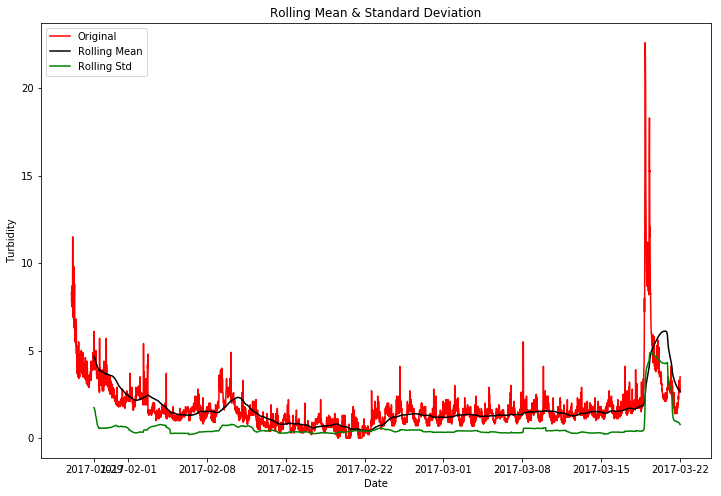

In [10]:
check_mean_std(dataset['Turb(FNU)'],'\n\nTurbidity')

## Plotting ACF and PACF plots to determine values of p and q for ARIMA Model

In [11]:
def acf_pacf_plots(dataset):
    ts_diff = dataset - dataset.shift()
    ts_diff.dropna(inplace=True)
    lag_acf = acf(ts_diff, nlags=20)
    lag_pacf = pacf(ts_diff, nlags=20, method='ols')
    
    # ACF
    plt.figure(figsize=(22,10))
    
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')
    
    # PACF
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()

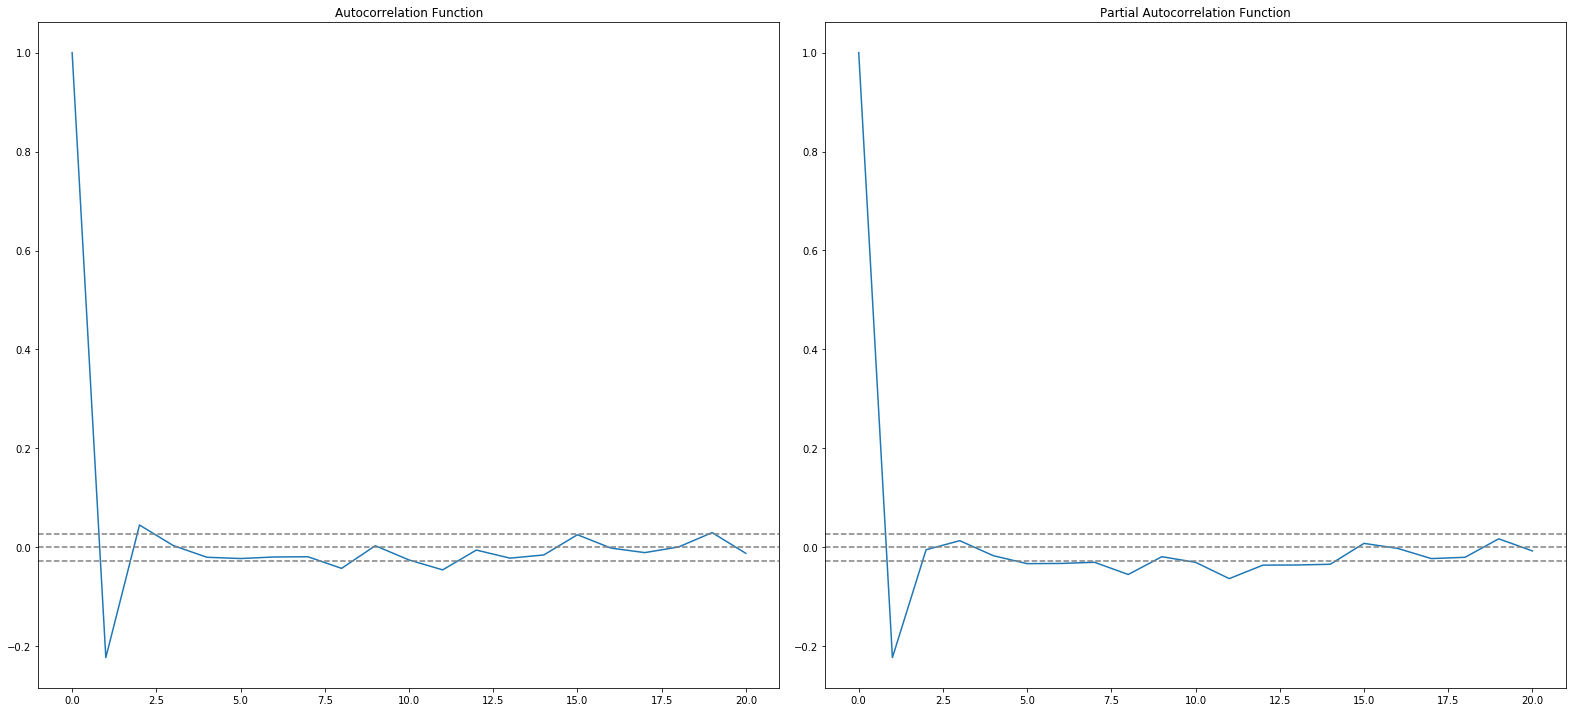

In [12]:
acf_pacf_plots(turb)

The first dip below the dotted line is considered as p by looking at the autocorrelation function while the first dip in Partial Autocorrelation Function is considered as q parameter. So by this plot we find p = 1 and q = 1

## Calculating a moving average of dataset to make dataset more stationary

In [16]:
# Moving average method for Turbidity
def moving_average():
    #turb_logScale = np.log(turb)
    #plt.plot(turb_logScale)

    turb_ma = turb.rolling(window=192).mean() #window size 192 denotes 1 day, giving rolling mean at daily level
    #sc_movingSTD = sc_logScale.rolling(window=192).std()

#   plt.plot(sc_logScale)
#plt.plot(sc_moving_Average, color='blue')
    
    
    plt.figure(figsize=(12,8))
    plt.plot(turb, color = "red",label = "Original")
    plt.plot(turb_ma, color='black', label = "turb moving_avg_mean")
    plt.title("Turbidity Rolling mean(mg/L) of Potomac River")
    plt.xlabel("Date")
    plt.ylabel("Turb(FNU)")
    plt.legend()
    plt.show()
    
    turb_ma_diff = turb - turb_ma
    #sc_LogScaleMinusMovingAverage.head(100)
    
    turb_ma_diff.dropna(inplace=True)
    #print(sc_rolmean,sc_rolstd)

    check_adfuller(turb_ma_diff['Turb(FNU)'])
    check_mean_std(turb_ma_diff['Turb(FNU)'], '\n\nTurbidity(FNU)')

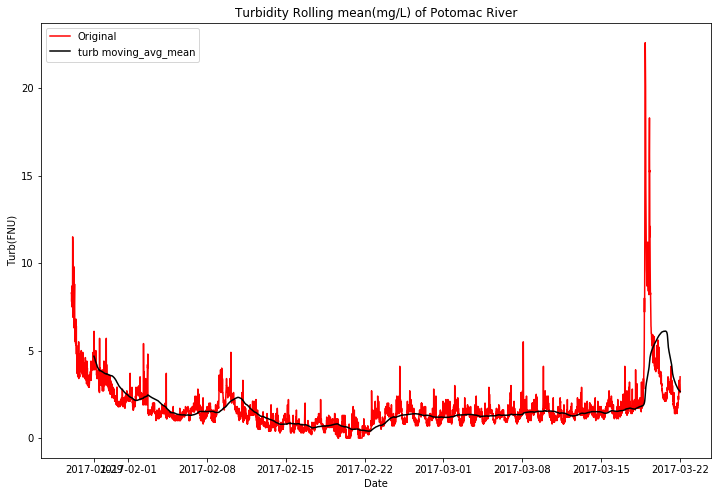

Results of Dickey Fuller Test:
--------For a stationary time series Test statistic is less than critical values-----------
Test Statistic                   -5.544052
p-value                           0.000002
#Lags Used                       31.000000
Number of Observations Used    4948.000000
Critical Value (1%)              -3.431672
Critical Value (5%)              -2.862124
Critical Value (10%)             -2.567081
dtype: float64


Turbidity(FNU)


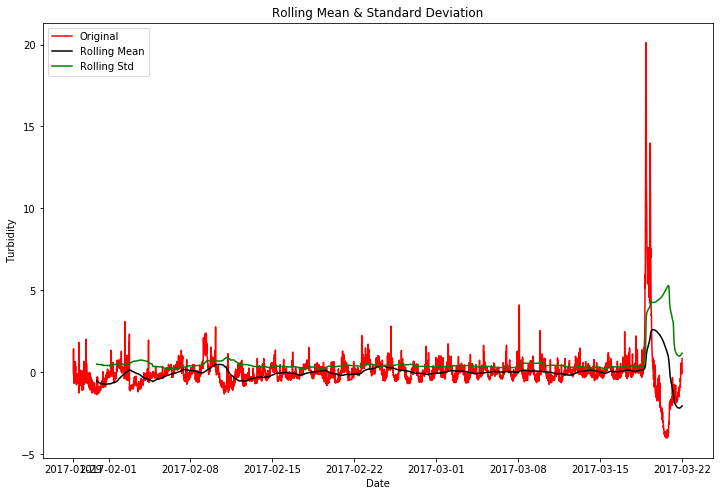

In [17]:
moving_average()

## Arima Model:

### There are mainly 2 methods of making forecasts:-
1. predict() : Used to make out of step, one step predictions
2. forecast() : Used to make 1 step ahead predictions

### Using Auto arima to find out the best seasonal parameters for dataset

In [11]:
# Import the library 
from pmdarima import auto_arima 
  
# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 
  
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(turb, start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,12) [intercept=True]; AIC=4889.870, BIC=4922.612, Time=24.122 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=14747.779, BIC=14760.876, Time=0.234 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=6821.953, BIC=6848.147, Time=5.164 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=10514.891, BIC=10541.085, Time=6.981 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=14746.632, BIC=14753.180, Time=0.156 seconds
Fit ARIMA(1,0,1)x(0,1,0,12) [intercept=True]; AIC=8220.695, BIC=8246.889, Time=2.070 seconds
Fit ARIMA(1,0,1)x(1,1,1,12) [intercept=True]; AIC=4890.690, BIC=4929.981, Time=28.032 seconds
Near non-invertible roots for order (1, 0, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,0,1)x(0,1,2,12) [intercept=True]; AIC=4888.995, BIC=4928.286, Time=75.850 seconds
Near non-invertible roots for order (1, 0, 1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 5171
Model:             SARIMAX(2, 0, 2)x(0, 1, [1], 12)   Log Likelihood               -2424.642
Date:                              Fri, 01 May 2020   AIC                           4863.284
Time:                                      21:03:58   BIC                           4909.124
Sample:                                           0   HQIC                          4879.325
                                             - 5171                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.573e-05    8.5e-05     -0.303      0.762      -0.000       0.000
ar.L1          0.8557      0.107      8.030      0.000       0.647       1.065
ar.L2          0.1132      0.104      1.088      0.277      -0.091       0.317
ma.L1         -0.0921      0.106     -0.867      0.386      -0.300       0.116
ma.L2          0.0411      0.020      2.008      0.045       0.001       0.081
ma.S.L12      -0.9905      0.002   -403.436      0.000      -0.995      -0.986
sigma2         0.1483      0.001    163.824      0.000       0.147       0.150
===================================================================================
Ljung-Box (Q):                      230.94   Jarque-Bera (JB):            243127.50
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                             1.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Training with whole dataset

In [50]:
# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(turb,  
                order = (2, 0, 2),  
                seasonal_order =(0, 1, 1, 12)) 
  
result = model.fit() 
result.summary() 

C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Turb(FNU)   No. Observations:                 5171
Model:             SARIMAX(2, 0, 2)x(0, 1, [1], 12)   Log Likelihood               -2419.413
Date:                              Sat, 02 May 2020   AIC                           4850.826
Time:                                      17:24:02   BIC                           4890.117
Sample:                                           0   HQIC                          4864.575
                                             - 5171                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0653      0.106     10.022      0.000       0.857       1.274
ar.L2         -0.0901      0.104     -0.867      0.386      -0.294       0.114
ma.L1         -0.3018      0.105     -2.861      0.004      -0.508      -0.095
ma.L2          0.0843      0.020      4.313      0.000       0.046       0.123
ma.S.L12      -0.9813      0.003   -299.303      0.000      -0.988      -0.975
sigma2         0.1484      0.001    166.941      0.000       0.147       0.150
===================================================================================
Ljung-Box (Q):                      218.49   Jarque-Bera (JB):            238945.16
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                             1.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Training SARIMA MODEL with whole dataset

In [54]:
# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(turb_train,  
                order = (2, 0, 2),  
                seasonal_order =(2, 1, 1, 12)) 
  
result = model.fit() 
result.summary() 

C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Turb(FNU)   No. Observations:                 3000
Model:             SARIMAX(2, 0, 2)x(2, 1, [1], 12)   Log Likelihood                -914.384
Date:                              Sat, 02 May 2020   AIC                           1844.769
Time:                                      17:27:52   BIC                           1892.788
Sample:                                           0   HQIC                          1862.044
                                             - 3000                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5496      0.112      4.906      0.000       0.330       0.769
ar.L2          0.4367      0.111      3.942      0.000       0.220       0.654
ma.L1         -0.0820      0.113     -0.726      0.468      -0.303       0.139
ma.L2         -0.3265      0.061     -5.334      0.000      -0.447      -0.207
ar.S.L12      -0.0167      0.015     -1.122      0.262      -0.046       0.012
ar.S.L24      -0.0005      0.015     -0.035      0.972      -0.030       0.029
ma.S.L12      -0.9827      0.005   -189.419      0.000      -0.993      -0.973
sigma2         0.1059      0.001     90.696      0.000       0.104       0.108
===================================================================================
Ljung-Box (Q):                      104.93   Jarque-Bera (JB):             23474.17
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                             0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predictions from start of turb_test to end 

In [55]:
#predictions with ARIMA
start = len(turb_train)
end = len(turb_train) +len(turb_test ) - 1
#start = end
#end = end + 2000
#start = parser('2017-02-16 00:15')
#end = parser('2017-03-21 23:45')
# Predictions for one-year against the test set 
predictions = result.predict(start, end, 
                             typ = 'linear').rename("Predictions") 
  


C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


#### Preparing Date index for turb_test

In [11]:
dataset2 = pd.read_csv('C:/users/admin/swq/Dataset/Data7.csv',header=0, delimiter=',', parse_dates=[0], date_parser=parser)


dataset2.head()

date = dataset2.filter(['date_time'], axis=1)

date.head()

date_test = date.iloc[3000:,0]

print(date_test.shape)

### Plotting the predictions made for turb_test standalone

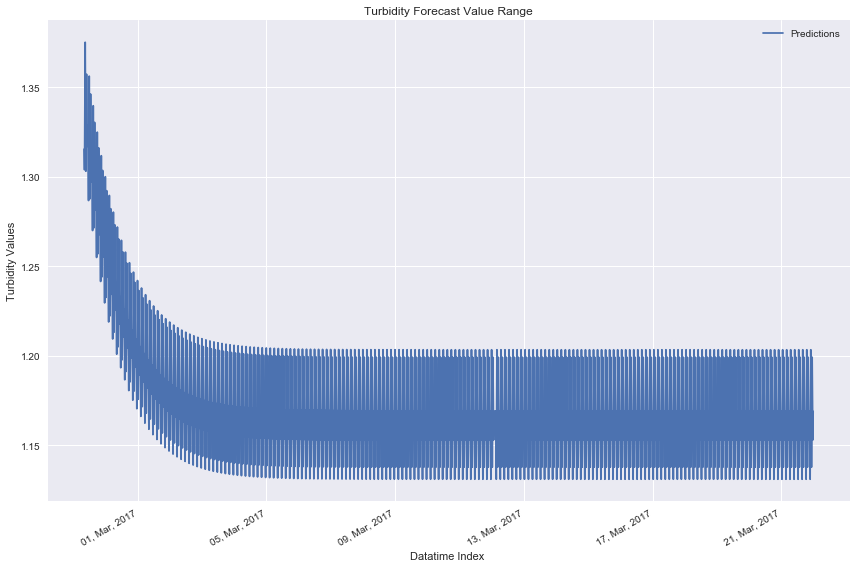

In [110]:
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.plot_date(date_test,predictions, linestyle='solid', marker='')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%d, %b, %Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.xlabel("Datatime Index ")
plt.ylabel("Turbidity Values")
plt.title('Turbidity Forecast Value Range')
plt.legend()
plt.tight_layout()

The above graph shows us a range of possible values in our test dataset

### SARIMAX Comparison Plot : Original vs Predicted  

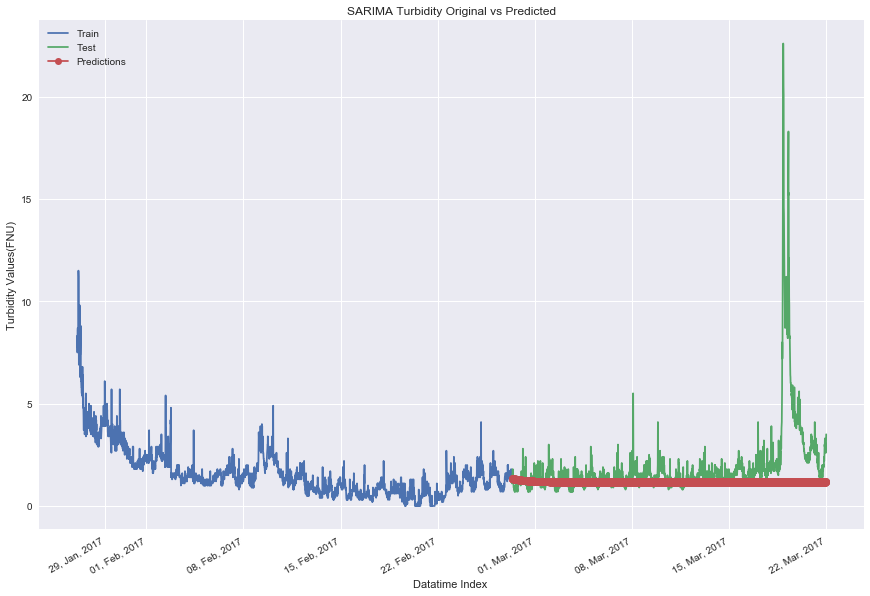

In [111]:
# plot predictions and actual values 

plt.style.use('seaborn')
plt.figure(figsize=(12,8))

plt.plot( turb_train, label='Train')
plt.plot(turb_test, label='Test')
plt.plot_date(date_test,predictions, linestyle='solid')
#plt.plot(predictions, label='Predictions')

plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%d, %b, %Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.tight_layout()
plt.xlabel("Datatime Index ")
plt.ylabel("Turbidity Values(FNU)")
plt.title('SARIMA Turbidity Original vs Predicted')
plt.legend()
plt.legend(loc='best')
plt.show()
#predictions.plot(legend = True) 
#turb_test.plot(legend = True) 

### Error Calculation

In [58]:
# Load specific evaluation tools 
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 
  
# Calculate root mean squared error 
print(rmse(turb_test, predictions))
  
# Calculate mean squared error 
print(mean_squared_error(turb_test, predictions))

[1.96989093 1.97338286 1.96259899 ... 2.01735873 2.02431418 2.01845642]
4.080466715686665


## Arima with a Differenced Series 

In [99]:
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
import numpy

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return numpy.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval):
    return yhat + history[-interval]

# load dataset
#series = read_csv('dataset.csv', header=None)
series = turb
# seasonal difference
X = series.values
day = 192#entries in a day
differenced = difference(X, day)
# fit model
model = ARIMA(differenced, order=(1,0,1))
model_fit = model.fit(disp=0)
# print summary of fit model
print(model_fit.summary())

#predictions with ARIMA
start = len(turb_train)
end = len(turb_train) +len(turb_test ) - 1

# predict
#forecast = model_fit.forecast()[0]
forecast2 = model_fit.predict(start, end)



                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 4979
Model:                     ARMA(1, 1)   Log Likelihood               -3922.216
Method:                       css-mle   S.D. of innovations              0.532
Date:                Sat, 02 May 2020   AIC                           7852.431
Time:                        18:37:59   BIC                           7878.483
Sample:                             0   HQIC                          7861.564
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1007      0.200     -0.502      0.615      -0.494       0.292
ar.L1.y        0.9700      0.004    270.838      0.000       0.963       0.977
ma.L1.y       -0.1961      0.014    -14.348      0.0

In [100]:
# invert the differenced forecast to something usable
forecast2_inverted = inverse_difference(X, forecast2, day)

### Plotting the predictions independently

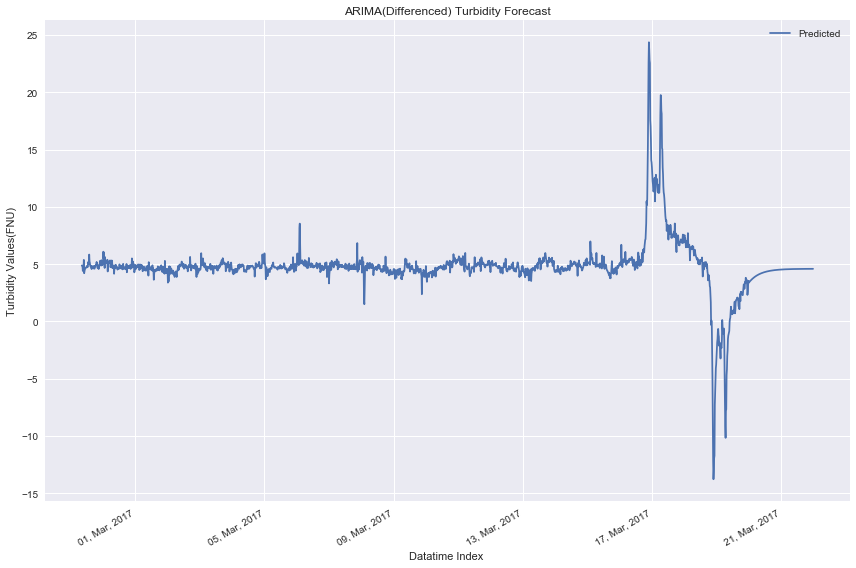

In [114]:
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.plot_date(date_test,forecast2_inverted, linestyle='solid', marker='',label='Predicted')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%d, %b, %Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.xlabel("Datatime Index ")
plt.ylabel("Turbidity Values(FNU)")
plt.title('ARIMA(Differenced) Turbidity Forecast')
plt.legend(loc='best')
plt.tight_layout()

### Comparison Original vs Predicted

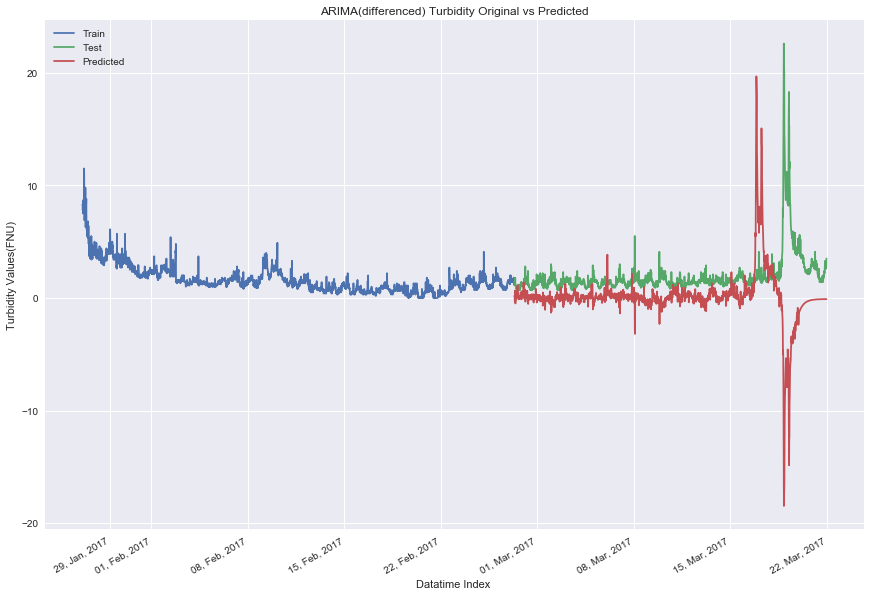

In [115]:
# plot predictions and actual values 

plt.style.use('seaborn')
plt.figure(figsize=(12,8))

plt.plot(turb_train, label='Train')
plt.plot(turb_test, label='Test')
plt.plot_date(date_test,forecast2, linestyle='solid',marker='',label='Predicted')
#plt.plot(predictions, label='Predictions')

plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%d, %b, %Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.tight_layout()
plt.xlabel("Datatime Index ")
plt.ylabel("Turbidity Values(FNU)")
plt.title('ARIMA(differenced) Turbidity Original vs Predicted')
plt.legend(loc='best')
plt.show()
#predictions.plot(legend = True) 
#turb_test.plot(legend = True) 

## ARIMA without differencing

In [105]:
# fit model:ARIMA
ts = turb_train
order=(1,0,1)
model = ARIMA(ts, order=order) # (ARMA) = (p,d,q)
model_fit = model.fit(disp=0)
#print summary of fit model
print(model_fit.summary())


C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:              Turb(FNU)   No. Observations:                 3000
Model:                     ARMA(1, 1)   Log Likelihood                -908.546
Method:                       css-mle   S.D. of innovations              0.327
Date:                Sat, 02 May 2020   AIC                           1825.093
Time:                        18:42:29   BIC                           1849.118
Sample:                             0   HQIC                          1833.734
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.3031      1.006      2.290      0.022       0.332       4.274
ar.L1.Turb(FNU)     0.9976      0.002    562.488      0.000       0.994       1.001
ma.L1.Turb(FNU)    -0.5856      

In [109]:
#predictions with ARIMA
start = len(turb_train)
end = len(turb_train) +len(turb_test ) - 1

In [106]:
# predict
#forecast = model_fit.forecast()[0]
forecast3 = model_fit.predict(start, end)

C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


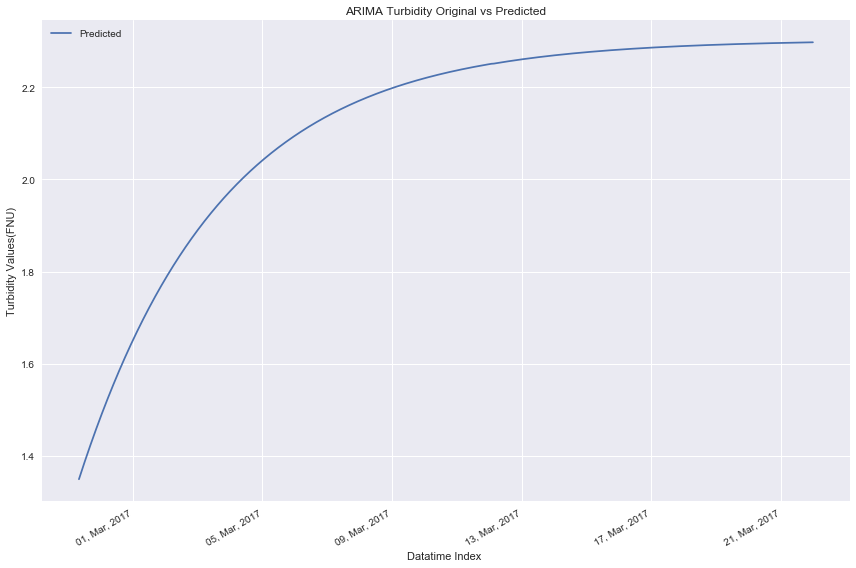

In [116]:
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.plot_date(date_test,forecast3, linestyle='solid', marker='',label='Predicted')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%d, %b, %Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.xlabel("Datatime Index ")
plt.ylabel("Turbidity Values(FNU)")
plt.title('ARIMA Turbidity Original vs Predicted')
plt.legend(loc='best')
plt.tight_layout()

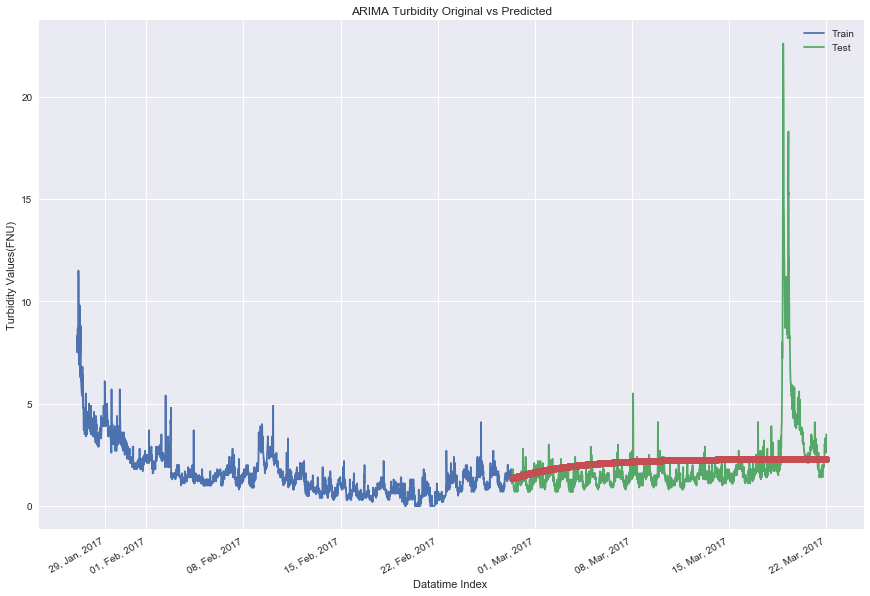

In [117]:
# plot predictions and actual values 

plt.style.use('seaborn')
plt.figure(figsize=(12,8))

plt.plot(turb_train, label='Train')
plt.plot(turb_test, label='Test')
plt.plot_date(date_test,forecast3, linestyle='solid')
#plt.plot(predictions, label='Predictions')

plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%d, %b, %Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.tight_layout()
plt.xlabel("Datatime Index ")
plt.ylabel("Turbidity Values(FNU)")
plt.title('ARIMA Turbidity Original vs Predicted')
plt.legend(loc='best')
plt.show()
#predictions.plot(legend = True) 
#turb_test.plot(legend = True) 

In [133]:
#Isolation Forest Model Prediction
train_size2,test_size2 = 1920, 3251#in paper given as 3169
#train_size,test_size = 3000, 2171

turb_train2,turb_test2 = tts(turb,train_size = train_size2, random_state=0, shuffle=False)
train2, test2 = turb_train2.values, turb_test2.values

model= IsolationForest(n_estimators=100, max_samples=256)
#model = IsolationForest(behaviour = 'new')
model.fit(turb_train2)
turb_pred = model.predict(turb_test2)
print("Valid cases Accuracy:", list(turb_pred).count(1)/turb_pred.shape[0])
Fraud_pred = model.predict(turb_test2)

Valid cases Accuracy: 0.7373115964318672


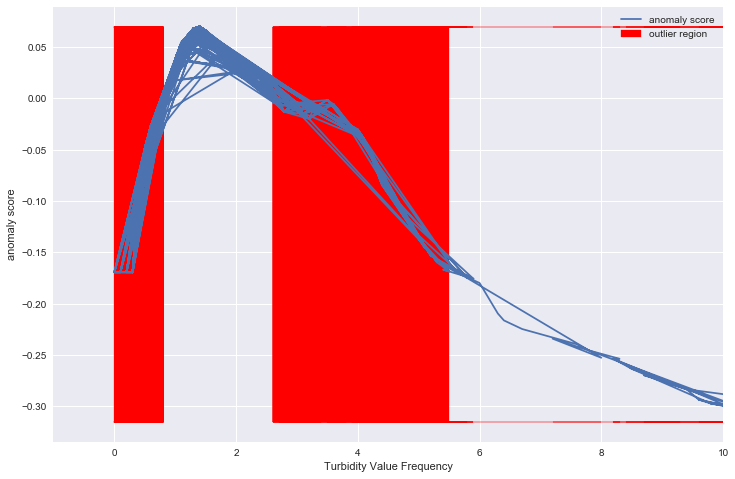

In [137]:

isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(train2.reshape(-1, 1))
#xx = np.linspace(-6, 6, 100).reshape(-1,1)
xx = test2.reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(12,8))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), where=outlier==-1, color='r', label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Turbidity Value Frequency')
plt.xlim([-1, 10])

plt.show()

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match

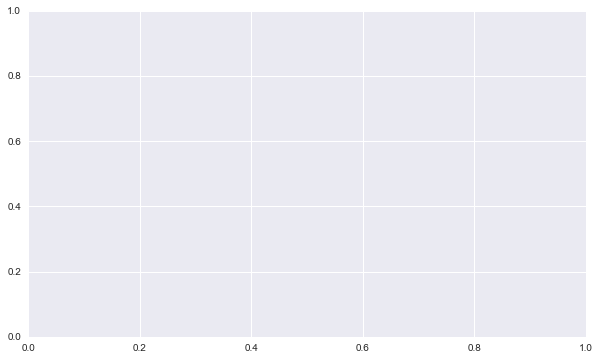

In [152]:
from sklearn.preprocessing import StandardScaler

data = turb
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# train isolation forest
outliers_fraction = 0.01
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 
anomaly = pd.Series(model.predict(data))

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = turb.loc[anomaly == -1] #anomaly

In [149]:
anomaly.head()

0    1
1    1
2    1
3    1
4    1
dtype: int32

In [ ]:
a = turb.loc[anomaly[0] == -1] #anomaly

ax.plot(data, color='blue', label = 'Normal')
ax.scatter(date,anomaly, color='red', label = 'Anomaly')
plt.legend()
plt.show();

In [138]:
turb.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5171 entries, 2017-01-27 00:00:00 to 2017-03-21 23:45:00
Data columns (total 1 columns):
Turb(FNU)    5171 non-null float64
dtypes: float64(1)
memory usage: 80.8 KB
